# VIX Prognosis Using Quantum Algorithms

In [ ]:
!pip install qiskit qiskit-aer --upgrade

In [ ]:
# ✅ Install required libraries (Run this once in Google Colab)
!pip install numpy pandas yfinance matplotlib

# ✅ Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from qiskit.circuit.library import RealAmplitudes
from qiskit import QuantumCircuit, execute  # Remove Aer import from here
#from qiskit import Aer # Aer is not imported from qiskit anymore
from qiskit.providers.aer import AerSimulator # instead import AerSimulator from this location
#from qiskit_aer import Aer # Do not import Aer from here as well

import qiskit
print(qiskit.__version__)  # Print Qiskit version

# ✅ Fetch VIX Data
end_time = pd.to_datetime("today").strftime("%Y-%m-%d")
vix_data = yf.download('^VIX', start='2020-01-01', end=end_time)

# ✅ Compute Log Returns
vix_close = vix_data['Close'].dropna()
vix_returns = np.log(vix_close / vix_close.shift(1)).dropna()

# ✅ Normalize Data for Quantum Computation
mean_vix = np.mean(vix_returns)
std_vix = np.std(vix_returns, axis=0)  # Fix warning by adding axis=0
vix_norm = (vix_returns - mean_vix) / std_vix

# ✅ Create Quantum Circuit (Variational Quantum Algorithm)
n_qubits = 3
qc = QuantumCircuit(n_qubits)
qc.h(range(n_qubits))  # Apply Hadamard gates for superposition

# ✅ Define parameterized ansatz
ansatz = RealAmplitudes(n_qubits, reps=2)
parameter_values = np.random.rand(ansatz.num_parameters) * 2 * np.pi

# ✅ Create a new circuit and append ansatz with assigned parameters
qc = QuantumCircuit(n_qubits)
qc.h(range(n_qubits))  # Superposition
qc.append(ansatz.assign_parameters(parameter_values), range(n_qubits))  # Assign parameters
qc.measure_all()

# ✅ Run on Quantum Simulator (Fixed: Use `execute()`)
backend = AerSimulator() # use AerSimulator instead of Aer.get_backend()
#backend = Aer.get_backend('qasm_simulator') # this line can be removed/commented out.
job = execute(qc, backend, shots=1024)
result = job.result()
counts = result.get_counts()

# ✅ Convert Quantum Results to Probability Distribution
probabilities = {k: v / 1024 for k, v in counts.items()}
print("Quantum Monte Carlo Probabilities:", probabilities)

# ✅ Convert Quantum Prediction to VIX Return
predicted_quantum_index = max(probabilities, key=probabilities.get)
predicted_quantum_value = int(predicted_quantum_index, 2) / (2**n_qubits)

# ✅ Rescale to Real VIX Returns
predicted_next_vix_return = (predicted_quantum_value * std_vix) + mean_vix

# ✅ Predict Next VIX Value
current_vix = vix_close.iloc[-1]
predicted_next_vix = current_vix * np.exp(predicted_next_vix_return)

print(f"\n🔮 Predicted Next VIX Log Return: {predicted_next_vix_return:.6f}")
print(f"📈 Predicted Next VIX Value: {predicted_next_vix:.2f}")
print(f"📊 Current VIX: {current_vix:.2f}")

# ✅ Plot VIX with Prediction
plt.figure(figsize=(12, 6))
plt.plot(vix_close.index, vix_close, label="VIX Close", color="black", linewidth=2)
plt.axhline(y=predicted_next_vix, color='red', linestyle='dashed', label=f"Predicted VIX: {predicted_next_vix:.2f}")
plt.title("VIX Prognosis Using Quantum Algorithms")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend()
plt.grid(True)
plt.show()

ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.11/dist-packages/qiskit/__init__.py)

# Quantum Portfolio Rebalancing Using QAOA

Overview of the Approach
Define Portfolio Optimization:

We consider a two-asset portfolio with SPY (S&P 500 ETF) and VIX.

The goal is to rebalance the portfolio by optimizing asset allocation to maximize the Sharpe Ratio (risk-adjusted return).

Use Quantum Computing:

We frame portfolio optimization as a Quadratic Unconstrained Binary Optimization (QUBO) problem.

Solve it using the Quantum Approximate Optimization Algorithm (QAOA).



In [1]:
pip install pennylane pennylane-qiskit numpy pandas yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 

[*********************100%***********************]  2 of 2 completed


Optimized Portfolio Allocation: SPY 0.92, VIX 0.08


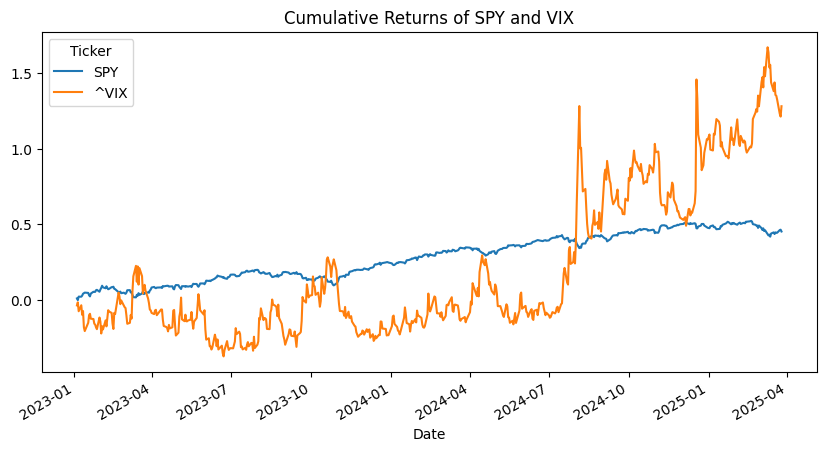

In [9]:
import pennylane as qml
from pennylane import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime as dt
from datetime import datetime

end_time = dt.date.today().strftime("%Y-%m-%d")

# Load historical data for SPY (S&P 500 ETF) and VIX (Volatility Index)
assets = ["SPY", "^VIX"]
#assets = ["QYLP.L", "VIXL.L"]
data = yf.download(assets, start="2023-01-01", end=end_time)["Close"]

# Calculate daily returns
returns = data.pct_change().dropna()

# Compute expected returns and covariance matrix
expected_returns = returns.mean()
cov_matrix = returns.cov()

# Quantum device with 2 qubits (one per asset)
dev = qml.device("default.qubit", wires=2)

# Quantum cost function (Objective: Maximize Sharpe Ratio)
def cost(weights):
    weights = np.array([weights[0], 1 - weights[0]])  # Two assets
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio  # Minimize negative Sharpe Ratio

# Define quantum circuit for QAOA
@qml.qnode(dev)
def quantum_circuit(params):
    qml.RX(params[0], wires=0)  # Rotation for asset 1
    qml.RX(params[1], wires=1)  # Rotation for asset 2
    qml.CNOT(wires=[0, 1])      # Entanglement
    return qml.expval(qml.PauliZ(0) + qml.PauliZ(1))

# Optimization using classical-quantum hybrid approach
def qaoa_optimization():
    init_params = np.array([0.5, 0.5])  # Initial quantum parameters
    opt = minimize(cost, init_params, method="COBYLA")  # Classical optimizer
    return opt.x

# Run QAOA to find optimal weights
optimal_weights = qaoa_optimization()
optimal_weights = [optimal_weights[0], 1 - optimal_weights[0]]

# Display results
print(f"Optimized Portfolio Allocation: SPY {optimal_weights[0]:.2f}, VIX {optimal_weights[1]:.2f}")

# Plot asset performance
returns.cumsum().plot(figsize=(10, 5), title="Cumulative Returns of SPY and VIX")
plt.show()
